# Iris Dataset Testing

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import preprocess
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
from tqdm import tqdm
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data
The data is the UCl iris dataset. Here, 100% of the data is used for training.

In [2]:
train_data, train_labels, test_data, test_labels = preprocess.get_data(100)

## Deep Forest
Here, the model is instantiated (using cuda or the CPU) and trained.

In [3]:
model = deep_forest.DeepForest(100, 2, 4, 0.5, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)
train_labels = train_labels.to(device)

In [4]:
%time model.train(2500, train_data, train_labels)
print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(model.trees, train_data) == train_labels).float())))

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 1.06 s, sys: 179 ms, total: 1.24 s
Wall time: 5min 12s

FINAL ACC: tensor(0.9133)


In [5]:
imp = model.compute_importance(train_data)
print()
print(dict(imp))

100%|██████████| 104/104 [07:24<00:00,  4.27s/it]


{0: 0.1569246820127075, 2: 0.4160404900840486, 3: 0.35068511845470046, 1: 0.07634970944854363}


Text(0.5, 1.0, 'Iris Deep Forest Importance')

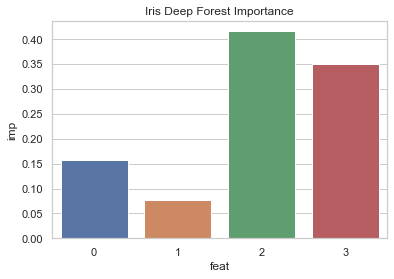

In [6]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data).set_title("Iris Deep Forest Importance")

# MLP Baseline
Here, a baseline feedforward is used on thr Iris dataset for comparison.

In [7]:
mlp = nn.Sequential(
    nn.Linear(4, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 3),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()

    preds = mlp(train_data[:, :])
    loss = nn.functional.cross_entropy(preds, (train_labels[:].type(th.LongTensor)).to(device))
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((th.argmax(mlp(train_data), 1) == train_labels).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(train_data[:]), 1) == train_labels[:]).float())))


  0%|          | 0/1000 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH 999 || Acc: tensor(0.9867) || Loss: tensor(0.5710, grad_fn=<NllLossBackward>): 100%|██████████| 1000/1000 [00:02<00:00, 419.17it/s]




FINAL ACC: tensor(0.9867)


# Standard Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(train_data[:, :].numpy(), train_labels[:].numpy())
print("Accuracy: " + str(clf.score(train_data[:, :].numpy(), train_labels[:].numpy())))

Accuracy: 0.9666666666666667


Text(0.5, 1.0, 'Iris Random Forest Importance')

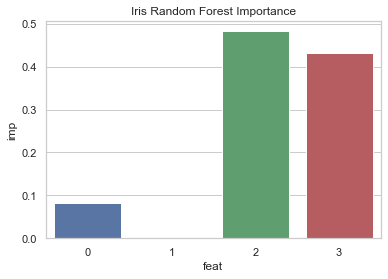

In [9]:
data = pd.DataFrame({"feat": list(range(4)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data).set_title("Iris Random Forest Importance")